# Dota Dataset Notebook 1 - Exploratory Data Analysis and Clustering

This is the first of a collection of notebooks that work on the Dota in-game chat messages. 

The dataset can be found here: https://www.kaggle.com/romovpa/gosuai-dota-2-game-chats. 

This notebook covers:
* Labeling languages of in-game chat messages
* Data cleaning (mainly of the language classifications)
* Exploratory data analysis
* K-means clustering

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import langdetect as ld
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

In [188]:
df = pd.read_csv('dota2_chat_messages.csv', nrows=20000)
df.head()

,match,time,slot,text
0,0,1005.12122,9,ладно гг
1,0,1005.85442,9,изи
2,0,1008.65372,9,од
3,0,1010.51992,9,ебаный
4,0,1013.91912,9,мусор на войде


In [189]:
df.shape

(20000, 4)

* Because langdetect and TextBlob take a while to run, the plan is to initially analyze and work with a subset of the Dota dataset (20,000 rows). The original dataset contains about 21 million rows. After creating a working solution for labeling texts by their languages, it will be applied to the entire dataset. This later resulted in about 7 million rows.

In [190]:
for col in df.columns:
    print(col, "NA:", sum(df[col].isna()))

match NA: 0
time NA: 0
slot NA: 0
text NA: 0


# Language Labeling & Data Cleaning 

In [191]:
# Labeling languages
langs = np.zeros(len(df)).astype(str)
i = -1
for message in df['text'].values:
    i += 1
    try:
        langs[i] = ld.detect(message)
    except:
        continue
df['language'] = langs

In [192]:
# Checking how acronyms were labeled, starting with "ez", then "lol", then "gg"
print(len(df[df['text'] != 'nan'][df['text'].str.contains('(ez)|(Ez)|(EZ)')]))
df[df['text'] != 'nan'][df['text'].str.contains('(ez)|(Ez)|(EZ)')].head()

589


,match,time,slot,text,language
39,2,2266.44690,4,EZ,es
109,4,2211.44192,6,ez,hu
112,5,349.58133,2,ez),hu
146,6,2483.09070,1,ez game,hu
151,6,2527.20770,1,SOOO EZQ!!,pt


In [193]:
df[df['text'] != 'nan'][df['text'].str.contains('(lol)|(Lol)|(LOL)')].head()

,match,time,slot,text,language
37,2,2263.369700,2,lol,es
168,8,-101.669062,5,nice random ... lol,hr
236,9,2082.705520,5,u play LOL,so
510,22,288.529560,6,lol,es
723,30,-19.062020,1,fuck off lol,en


In [194]:
df[df['text'] != 'nan'][df['text'].str.contains('(gg)|(Gg)')].head()

,match,time,slot,text,language
145,6,2307.59290,8,gg,tl
148,6,2525.16750,0,gg,tl
149,6,2525.16750,3,gg,tl
150,6,2525.53530,2,gg,tl
165,7,1940.70763,0,gg,tl


To summarize the acronym portion, many more were checked but removed due to redundancy. Overall, langdetect was not trained on gamer terms, especially acronyms. Terms such as "ez", "lol", "gg", "noob", etc. are acronyms of English words specifically, but they were classified as different languages. These misclassified languages will be manually fixed. 

In [195]:
# Fixing some languages due to acronyms
lang_fix = df.copy()
lang_fix = lang_fix.mask(df['text'].str.contains('(ez)|(Ez)|(EZ)'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('(lol)|(Lol)|(LOL)'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('(gg)|(Gg)|(GG)'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('(ty)|(Ty)|(TY)'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('(xD)|(XD)'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('[Rr]eport'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('STUPID|[Ss]tupid'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('[Ff][Uu][Cc][Kk]|[Ss]hit'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('[Nn][Oo][Oo][Bb]'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('retard|RETARD'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('pls|stfu|omg|OMG|wtf|WTF|wp|guys|kill|KILL|god|feed|FEED|btw'),'en')
lang_fix = lang_fix.mask(df['text'].str.contains('idiot|IDIOT|defend|dumb|end'), 'en')
lang_fix = lang_fix.mask(df['text'].str.contains('good|game|nice|thx|THX'), 'en')
df['language'] = lang_fix['language']

Some text cells only contain two to four characters, which could lead to an inaccurate reading. Languages may be the same within a particular match and slot combination, especially since players within the same match would mean they are in the same region. A possibility is to fix these incorrect readings by taking the majority language within the match or within the specific match and slot.

In [196]:
display(df[df['match'] == 476].sort_values('slot'),
        df[df['match'] == 476].sort_values('slot').groupby('language').size())

,match,time,slot,text,language
9935,476,2880.89361,0,такого дурачка не вытянуть,ru
9923,476,2285.53231,0,репорт тинкера,mk
9924,476,2288.20811,0,пожалуйста,ru
9925,476,2290.75011,0,просто мусор,ru
9933,476,2874.33801,0,хули тут,uk
...,...,...,...,...,...
9955,476,3012.27461,9,гг вп,ru
9915,476,1173.16761,9,ахаха,ru
9904,476,947.35611,9,в стороне стоим и похуй,ru
9903,476,941.29091,9,тима заебись,bg


language
0.0     3
bg      9
en      1
mk     15
ru     44
uk      5
dtype: int64

For the example above, match 476 mostly consists of the Russian language. Due to this, can we assign all other text within the match as Russian? Let's look at a different match.

In [197]:
display(df[df['match'] == 471].sort_values('slot').tail(15),
        df[df['match'] == 471].sort_values('slot').groupby('language').size())

,match,time,slot,text,language
9799,471,1796.72603,7,xD,en
9793,471,1191.67573,7,THX,en
9789,471,621.84818,7,NOOB,en
9788,471,620.84843,7,THX,en
9801,471,1815.38953,7,smart paly,en
9804,471,2104.24013,8,focus me,ca
9791,471,776.77703,8,ok,sk
9813,471,2177.08833,8,gege,af
9803,471,1992.52623,9,MEU DEUS,de
9816,471,2184.51363,9,gg wp,en


language
af     1
ca     1
da     1
de     4
en    17
es     1
et     1
pt     4
sk     1
so     2
sq     1
tl     1
dtype: int64

For a match such as 471, player 9 is speaking in Portuguese while the other players are speaking in English. Taking the majority language of a match would not work, but taking the majority language of a match and slot combination would. Rows of the same match and slot number are chat messages by the same person.

In [198]:
display(df[df['match'] == 471][df['slot']==7], 
        df[df['match'] == 471][df['slot']==9])

,match,time,slot,text,language
9788,471,620.84843,7,THX,en
9789,471,621.84818,7,NOOB,en
9793,471,1191.67573,7,THX,en
9799,471,1796.72603,7,xD,en
9800,471,1810.70683,7,good thing you Ulti a supp4,en
9801,471,1815.38953,7,smart paly,en
9810,471,2167.25483,7,LOL,en
9811,471,2172.20503,7,KILL ME BRO,en
9812,471,2176.08483,7,AHAHAHAH,tl
9815,471,2182.50683,7,ez top,en


,match,time,slot,text,language
9783,471,-169.33847,9,3 disputando mid e um alch hc,pt
9784,471,-161.60348,9,perdemos esse jogo,pt
9795,471,1387.69453,9,desde o começo,pt
9803,471,1992.52623,9,MEU DEUS,de
9808,471,2120.29483,9,milagre ganhar com um alch,pt
9809,471,2132.26893,9,vou te commendar por provar minha teoria de 'a...,en
9816,471,2184.51363,9,gg wp,en


Using players 7 and 9 of match 471, it is shown that it is better to correct misclassified languages depending on the majority language class of that one specific player.

In [199]:
# For each match and slot pair, find the majority language and assign all of them as that language
match_slot_pairs = df.groupby(['match', 'slot']).size().index
for match, slot in match_slot_pairs:
    tmp = df[(df['match']==match) & (df['slot']==slot)]
    majority_s = tmp['language'].value_counts().sort_values(ascending=False)
    majority_lang = majority_s.index[0]
    
    # if the top 2 languages are tied...
    if len(majority_s) > 1:
        if (majority_s[0] == majority_s[1]):
            # then pick the one with the longest text (more words = more accurate lang label)
            two_top_langs = tmp[(tmp['language']==majority_s.index[0]) | (tmp['language']==majority_s.index[1])]
            longest_index = two_top_langs['text'].str.len().sort_values(ascending=False).index[0]
            majority_lang = df.iloc[longest_index,]['language']
    
    df['language'] = df.mask((df['match']==match) & (df['slot']==slot), majority_lang)['language']

Looking at player 9 of match 471 again, that player's texts should now all be labeled as Portuguese.

In [200]:
df[df['match'] == 471][df['slot']==9]

,match,time,slot,text,language
9783,471,-169.33847,9,3 disputando mid e um alch hc,pt
9784,471,-161.60348,9,perdemos esse jogo,pt
9795,471,1387.69453,9,desde o começo,pt
9803,471,1992.52623,9,MEU DEUS,pt
9808,471,2120.29483,9,milagre ganhar com um alch,pt
9809,471,2132.26893,9,vou te commendar por provar minha teoria de 'a...,pt
9816,471,2184.51363,9,gg wp,pt


# Exploratory Data Analysis

### We will be using the English portion of the Dota dataset.

In [201]:
eng = df[df['language']=='en'].drop('language', axis=1)
eng.head()

,match,time,slot,text
25,2,1248.4285,0,yes dog
27,2,1281.9536,4,HAHAH
28,2,1559.0526,0,yeah
29,2,1563.1849,0,fast and furious
30,2,1757.5132,0,too fas


In [202]:
eng.describe()

,match,time,slot
count,8715.000000,8715.000000,8715.000000
mean,480.820654,1526.197430,4.420884
std,288.625234,917.923657,2.865315
min,2.000000,-657.122182,0.000000
25%,227.000000,835.096100,2.000000
50%,471.000000,1608.140620,5.000000
75%,733.000000,2129.536790,7.000000
max,975.000000,4533.448760,9.000000


In [203]:
eng.dtypes

match      int64
time     float64
slot       int64
text      object
dtype: object

In [204]:
eng.shape

(8715, 4)

In [205]:
print("There are about {} messages in English.".format(eng.shape[0]))

There are about 8715 messages in English.


### Match

In [206]:
eng['match'].value_counts().head(10)

227    165
121    156
972    147
444    114
235    104
183    101
953     98
554     82
290     76
491     75
Name: match, dtype: int64

The most amount of messages sent during one match is 165.

In [207]:
print("On average, one match has {} messages sent if at least one message was sent.".format(round(eng['match'].value_counts().mean())))

On average, one match has 13 messages sent if at least one message was sent.


In [208]:
print("There are about {} matches in English.".format(len(eng.groupby('match').size().index)))

There are about 697 matches in English.


In [209]:
# Unique match + slot combos = num players
num_players = len(eng.groupby(['match', 'slot']).size().index)
print("There are about {} players in our English data set.".format(num_players))

There are about 1899 players in our English data set.


### Time

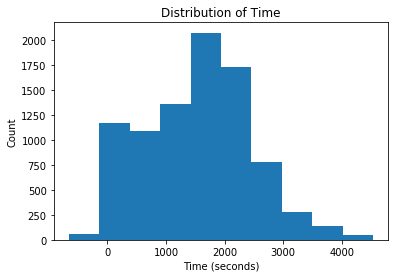

In [210]:
# Distribution of the timestamps of messages
plt.hist(eng['time'])
plt.xlabel('Time (seconds)')
plt.ylabel('Count')
plt.title('Distribution of Time');

In [211]:
print("max:", round(eng['time'].max()), "| min:", round(eng['time'].min()), "| mean:", round(eng['time'].mean()))

max: 4533 | min: -657 | mean: 1526


* On average, messages are mostly sent around 1525 seconds/25 minutes into the game.

In [212]:
eng[eng['time'] < 0].sort_values('time').head(10)

,match,time,slot,text
4426,203,-657.122182,5,OMG
4427,203,-649.788960,5,IT'S REALLY HAPPENING
4185,188,-394.015630,2,hey
7360,339,-353.087927,4,dicen que ppk la tiene negra
5807,258,-352.420780,3,PUDGE
5808,258,-350.020816,3,WHY PUDGE
5809,258,-348.287510,3,PIOCK MID
5810,258,-346.620870,3,TRASH
8658,414,-332.495660,0,why you ban berd
8659,414,-329.962365,0,iz my berd


* The highly negative time chats talk about banning champs, questioning champ selections, and picking lanes.
* Negative seconds indicate time before the match has started (i.e. hero selection).

In [213]:
eng[eng['time'] < 0].sort_values('time').tail(10)

,match,time,slot,text
7129,328,-3.96570,8,lol
3637,165,-2.46719,7,gg
19162,947,-2.16713,8,WHY?
4138,185,-2.16614,0,w8 2 more sex
4428,204,-1.53296,9,xD
2027,102,-1.49963,7,s
11245,538,-1.26694,6,YA TIENES MI COMEND
18142,891,-0.93354,3,AND THE TING GOES
11246,538,-0.66681,0,report omini
9989,478,-0.06668,7,DE NUEVO ESE LEGION CACA ME TOCA


* The least negative chats (when the game is about to begin) do not indicate much, but there is one entry that says to wait 2 more seconds, which was sent at a time of -2. This further indicates that negative time indicates the seconds before the match begins.
> **Note:** There are still some misclassified languages. This notebook was for some quick eda, so a quick solution for language labeling was sought. In addition, langdetect took too long for the 21 million rows. Later on, FastText was used.

Displaying examples of messages sent when a game starts vs. when a game ends.

In [214]:
eng[eng['time'] >= 0].sort_values('time').head(10)

,match,time,slot,text
7614,359,0.00000,2,afker
3683,166,0.03334,3,script for what?
11247,538,0.26673,0,:)
7624,359,0.86685,4,25?!?!?!?
7620,359,0.86685,2,30 sec no response i go
7619,359,0.86685,9,what is repor?
7618,359,0.86685,5,you forgot the T
7617,359,0.86685,4,REPOR
7616,359,0.86685,4,REPOR
7621,359,0.86685,4,OK


In [215]:
eng[eng['time'] >= 0].sort_values('time').tail(10)

,match,time,slot,text
16639,809,4285.82315,3,wp
16640,809,4286.35455,7,gg
16641,809,4286.75285,5,GG EU
16642,809,4288.77825,8,GG w´p
16643,809,4290.63755,8,report void
5516,237,4511.84234,9,GG
12834,600,4514.45676,4,gg
12835,600,4523.08936,9,GG WP
12836,600,4524.81576,2,gg wp
12840,600,4533.44876,2,like


### Slot

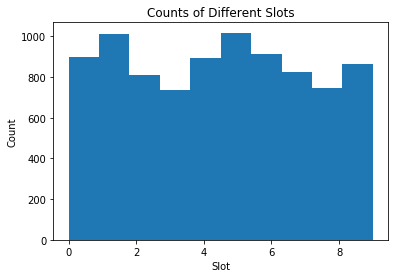

In [216]:
plt.hist(eng['slot'])
plt.xlabel('Slot')
plt.ylabel('Count')
plt.title('Counts of Different Slots');

Radiant and Dire correspond to the two different teams within one match. The team that spawns at the bottom left half of the map is the Radiant team, whereas the team that spawns at the top right half of the map is the Dire team.

In [217]:
# Slot number 0-4: Radiant
print("Number of Radiant messages:", sum(eng[eng['slot'] < 5]['slot'].value_counts()))
eng[eng['slot'] < 5]['slot'].value_counts()

Number of Radiant messages: 4345


1    1010
0     897
4     896
2     808
3     734
Name: slot, dtype: int64

In [218]:
# Slot number 5-9: Dire
print("Number of Dire messages:", sum(eng[eng['slot'] >= 5]['slot'].value_counts()))
eng[eng['slot'] >= 5]['slot'].value_counts()

Number of Dire messages: 4370


5    1018
6     914
9     865
7     827
8     746
Name: slot, dtype: int64

* There is virtually no difference in the amount of messages the two teams send, although Radiant teams tend to have a higher winrate (https://www.reddit.com/r/DotA2/comments/aww7ob/radiant_has_an_unacceptable_win_rate_advantage_in/).

In [219]:
eng.groupby(['match', 'slot']).size().sort_values(ascending=False).head()

match  slot
121    1       84
235    5       81
227    5       61
953    2       53
318    6       52
dtype: int64

* The most amount of messages sent by one person in one match is 84.

In [220]:
print("The average amount of messages one player sends in one match is {}."
      .format(round(eng.groupby(['match', 'slot']).size().sort_values(ascending=False).mean())))

The average amount of messages one player sends in one match is 5.


### Text

**Most common messages:**

In [221]:
eng['text'].str.lower().value_counts().head(15)

gg        706
lol       238
ez        214
xd        180
?         133
ggwp      102
gg wp      92
wp         64
ty         61
haha       52
end        51
wtf        46
:d         34
ok         31
report     25
Name: text, dtype: int64

**Most common unigrams:**

In [222]:
split_texts = eng['text'].str.lower().str.split(" ").values
first_text = split_texts[0]
for texts in split_texts[1:]:
    first_text += texts
    
pd.Series(first_text).value_counts().head(15)

gg        963
          485
ez        458
lol       306
i         270
report    249
u         243
you       213
xd        206
wp        205
?         203
me        168
mid       154
is        147
and       144
dtype: int64

**Most common bigrams:**

In [223]:
bigrams = []
for row in eng['text'].values:
    bigrams += TextBlob(row).ngrams(2)

pd.Series(bigrams).astype(str).value_counts().head(10)

['gg', 'wp']          87
['Clock', 'Clock']    42
['ez', 'mid']         31
['my', 'team']        27
['GG', 'WP']          22
['ez', 'game']        19
['this', 'game']      18
['kill', 'me']        16
['commend', 'me']     15
['you', 'know']       15
dtype: int64

**Most common trigrams:**

In [224]:
trigrams = []
for row in eng['text'].values:
    trigrams += TextBlob(row).ngrams(3)
    
pd.Series(trigrams).astype(str).value_counts().head(10)

['Clock', 'Clock', 'Clock']    35
['know', 'the', 'wey']         12
['you', 'know', 'the']         12
['Do', 'you', 'know']          12
['UGANDA', 'NEEEDS', 'UR']     11
['NEEEDS', 'UR', 'HELP']       11
['happy', 'new', 'year']        6
['nice', 'death', 'propet']     6
['hahaha', 'nice', 'death']     6
['let', 'us', 'end']            5
dtype: int64

* **Note:** This could include spam by one person (one person sending the same message multiple times).

# Initial Feature Selection

**Text length as a feature:**

In [226]:
eng['text length'] = [len(text) for text in eng['text']]
eng.head()

,match,time,slot,text,text length
25,2,1248.4285,0,yes dog,7
27,2,1281.9536,4,HAHAH,5
28,2,1559.0526,0,yeah,5
29,2,1563.1849,0,fast and furious,16
30,2,1757.5132,0,too fas,7


**Number of messages sent by that player as a feature:**

In [227]:
# getting num messages sent by that player, determined by unique match and slot combinations
num_messages = eng.groupby(['match', 'slot']).size()
num_messages = pd.DataFrame(num_messages).rename({0: 'num messages'}, axis=1)

eng['index'] = eng.index
eng = eng.set_index(['match', 'slot'])
eng = eng.join(num_messages).reset_index().sort_values('index').set_index('index')
eng.head()

,match,slot,time,text,text length,num messages
index,,,,,,
25,2,0,1248.4285,yes dog,7,6
27,2,4,1281.9536,HAHAH,5,3
28,2,0,1559.0526,yeah,5,6
29,2,0,1563.1849,fast and furious,16,6
30,2,0,1757.5132,too fas,7,6


**Polarity and subjectivity as features:**
* In sentiment analysis, polarity refers to sentiment orientation (positive, neutral, and negative)
* Subjectivity refers to the extent the text is stating a fact or an opinion/personal feeling.

In [235]:
# getting polarity and subjectivity with TextBlob
eng['polarity'] = eng['text'].apply(lambda x: TextBlob(x).sentiment[0])
eng['subjectivity'] = eng['text'].apply(lambda x: TextBlob(x).sentiment[1])
display(eng.sort_values('polarity', ascending=False).head(10), 
        eng.sort_values('polarity', ascending=False).tail(10))

,match,slot,time,text,text length,num messages,polarity,subjectivity
index,,,,,,,,
17534,853,0,788.21682,Best team,9,3,1.0,0.3
4422,201,0,1858.60084,GG COMMEND PLS <3,17,2,1.0,1.0
16764,818,8,372.84232,=D,2,11,1.0,1.0
6079,276,0,962.50142,wohohoh huskar commended :D,27,3,1.0,1.0
10475,495,2,869.32490,:D,2,9,1.0,1.0
18109,889,1,1765.50734,mirana do smthg :D,18,24,1.0,1.0
18105,889,1,1501.99994,25 min :D,9,24,1.0,1.0
988,43,3,725.05630,:D,2,20,1.0,1.0
18111,889,1,2095.49804,luna :D,7,24,1.0,1.0


,match,slot,time,text,text length,num messages,polarity,subjectivity
index,,,,,,,,
137,6,1,876.45270,STUPID!,7,16,-1.0,1.0
5480,235,5,1958.52426,give me the 4 worst players in all of dota,42,81,-1.0,1.0
19045,942,7,1781.22940,ITS INSANE,10,14,-1.0,1.0
14586,711,1,2794.23192,pathetic,8,14,-1.0,1.0
131,6,1,414.23220,WORST HOOK IN HISTORY,21,16,-1.0,1.0
6424,294,6,2201.37533,pathetic AM pick in unranked,28,5,-1.0,1.0
16023,772,6,1217.30272,fucking terrible sia,20,14,-1.0,1.0
14029,683,8,3033.94722,idiot jugg!!!!!!,16,6,-1.0,0.8
1659,83,6,141.16552,Worst country of the world,26,46,-1.0,1.0


**Number of caps in each text:**

In [250]:
capitals = []
for text in eng['text']:
    num_upper = sum([letter.isupper() for letter in text])
    capitals.append(num_upper)
eng['num caps'] = capitals
eng.head()

,match,slot,time,text,text length,num messages,polarity,subjectivity,num caps
index,,,,,,,,,
25,2,0,1248.4285,yes dog,7,6,0.0,0.0,0
27,2,4,1281.9536,HAHAH,5,3,0.0,0.0,5
28,2,0,1559.0526,yeah,5,6,0.0,0.0,0
29,2,0,1563.1849,fast and furious,16,6,0.2,0.6,0
30,2,0,1757.5132,too fas,7,6,0.0,0.0,0


### Summary of new features:

In [253]:
eng.describe()

,match,slot,time,text length,num messages,polarity,subjectivity,num caps
count,8715.000000,8715.000000,8715.000000,8715.000000,8715.000000,8715.000000,8715.000000,8715.000000
mean,480.820654,4.420884,1526.197430,9.912909,14.351692,0.037524,0.158615,1.149742
std,288.625234,2.865315,917.923657,9.928300,15.869183,0.272049,0.309764,3.556417
min,2.000000,0.000000,-657.122182,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,227.000000,2.000000,835.096100,3.000000,4.000000,0.000000,0.000000,0.000000
50%,471.000000,5.000000,1608.140620,7.000000,9.000000,0.000000,0.000000,0.000000
75%,733.000000,7.000000,2129.536790,13.000000,18.000000,0.000000,0.000000,0.000000
max,975.000000,9.000000,4533.448760,112.000000,84.000000,1.000000,1.000000,68.000000


In [284]:
print("Mean polarity per match: {}".format(
    round(eng.groupby('match').mean()['polarity'].sort_values().mean(), 5)))

Mean polarity per match: 0.03524


In [286]:
print("Mean polarity per player: {}".format(
    round(eng.groupby(['match', 'slot']).mean()['polarity'].sort_values().mean(), 5)))

Mean polarity per player: 0.04267


In [276]:
eng[(eng['match']==565) & (eng['slot']==5)]

,match,slot,time,text,text length,num messages,polarity,subjectivity,num caps
index,,,,,,,,,
11920,565,5,2030.9335,crystals = skeleton farming idiot,33,1,-0.8,0.8,0


In [296]:
print("\n Mean polarities of players that have sent many messages:")
eng.groupby(['match', 'slot']).mean().sort_values('num messages', ascending=False).head(10)


 Mean polarities of players that have sent many messages:


,,time,text length,num messages,polarity,subjectivity,num caps
match,slot,,,,,,
121,1,1540.638456,9.119048,84.0,0.033532,0.192744,0.297619
235,5,1722.899241,15.950617,81.0,-0.067622,0.309783,4.703704
227,5,1842.782288,8.836066,61.0,0.034426,0.168852,0.000000
953,2,2778.981500,9.679245,53.0,0.083019,0.083019,1.075472
491,3,1853.525548,9.673077,52.0,-0.017308,0.076923,1.153846
318,6,1531.424113,6.538462,52.0,0.189423,0.254808,0.346154
972,2,941.176477,9.725490,51.0,0.054902,0.125163,0.490196
83,6,377.696193,17.565217,46.0,-0.028261,0.233605,1.021739
227,0,1871.523916,10.600000,45.0,0.009074,0.184074,0.333333


In [298]:
# Looking at the messages sent by the player who sent the most messages
eng[(eng['match']==121) & (eng['slot']==1)]

,match,slot,time,text,text length,num messages,polarity,subjectivity,num caps
index,,,,,,,,,
2526,121,1,-80.45853,gotta love to see ur underlord now,34,84,0.5,0.600000,0
2530,121,1,-61.78787,no really,9,84,-0.1,0.200000,0
2531,121,1,-59.72076,do u see ur mama,16,84,0.0,0.000000,0
2532,121,1,-55.78659,imma piss on her,16,84,0.0,0.000000,0
2538,121,1,190.08691,nice stick,10,84,0.6,1.000000,0
...,...,...,...,...,...,...,...,...,...
2678,121,1,2443.24945,and feels bad,13,84,-0.7,0.666667,0
2679,121,1,2445.12245,for u man,9,84,0.0,0.000000,0
2684,121,1,2456.16005,haha,4,84,0.2,0.300000,0


* Looking at only one player's messages, it is already easy to determine that TextBlob's measure of polarity in gaming contexts is highly faulty. 
* TextBlob's subjectivity does not seem useful here either.

These features will not be used in the future, but for this notebook, it will continue to be used for data exploration.

# K-Means Clustering
K-means clustering will be used with the goal of doing more data exploration by observing any natural clusters. K-means clustering is a suitable technique here because there are no labels for the texts, and this method is the most common unsupervised learning method.

In [366]:
from sklearn import cluster, metrics
from sklearn.feature_extraction.text import TfidfVectorizer

# representing texts/words as numeric vectors so they can be usable by k-means
text_vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95, ngram_range=(1, 6), stop_words='english')
text_vectorizer.fit(eng['text'])
X = text_vectorizer.transform(eng['text']).todense()
X = np.append(X, eng_cluster[['text length', 'num messages', 'polarity', 'subjectivity', 'num caps']], axis=1)

# clustering
kmeans_model = cluster.KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1,random_state=5).fit(X)
eng_cluster['cluster'] = kmeans_model.labels_

In [367]:
display(eng_cluster[eng_cluster['cluster'] == 0].mean()[3:8],
       eng_cluster[eng_cluster['cluster'] == 1].mean()[3:8],
       eng_cluster[eng_cluster['cluster'] == 2].mean()[3:8],
       eng_cluster[eng_cluster['cluster'] == 3].mean()[3:8])

text length     10.942685
num messages    57.625943
polarity         0.022319
subjectivity     0.179288
num caps         1.547511
dtype: float64

text length      8.193355
num messages    24.570261
polarity         0.034348
subjectivity     0.146883
num caps         1.615468
dtype: float64

text length     29.163721
num messages     9.328372
polarity         0.013558
subjectivity     0.250581
num caps         2.173953
dtype: float64

text length     6.368800
num messages    6.171951
polarity        0.045631
subjectivity    0.140909
num caps        0.717954
dtype: float64

* Cluster 0: Very many messages sent
* Cluster 1: A sort of middle ground regarding the number of messages sent
* Cluster 2: Very long but few messages
* Cluster 3: Very short and few messages (seems more casual)

In [368]:
for cluster in range(4):
    print("Rows in cluster {}:".format(cluster), len(eng_cluster[eng_cluster['cluster'] == cluster]))

Rows in cluster 0: 663
Rows in cluster 1: 1836
Rows in cluster 2: 1075
Rows in cluster 3: 5141


Observing the type of messages sent in each cluster:

In [370]:
eng_cluster[eng_cluster['cluster'] == 0].head(10)

,match,slot,time,text,text length,num messages,polarity,subjectivity,num caps,cluster
index,,,,,,,,,,
1633,83,6,-55.21985,well if you remuse it will be uncount map,41,46,0.00,0.000000,0,0
1644,83,6,139.23266,??? lol now pause,17,46,0.80,0.700000,0,0
1646,83,6,139.23266,just remake,11,46,0.00,0.000000,0,0
1650,83,6,139.23266,this trash russian,18,46,0.00,0.000000,0,0
1653,83,6,140.33239,why not pause at first ???,26,46,0.25,0.333333,0,0
1654,83,6,140.89892,???????,7,46,0.00,0.000000,0,0
1657,83,6,141.16552,haha russian,12,46,0.10,0.150000,0,0
1659,83,6,141.16552,Worst country of the world,26,46,-1.00,1.000000,1,0
1662,83,6,141.16552,hey dog russians,16,46,0.00,0.000000,0,0


In [358]:
eng_cluster[eng_cluster['cluster'] == 1].head(10)

,match,slot,time,text,text length,num messages,polarity,subjectivity,num caps,cluster
index,,,,,,,,,,
120,6,1,13.7300,reprot,6,16,0.0,0.0,0,1
122,6,1,241.3744,SAD,3,16,-0.5,1.0,3,1
134,6,1,626.7803,YOU THOUGHT,11,16,0.0,0.0,10,1
136,6,1,874.7864,STUPIDD PIUDGE,14,16,0.0,0.0,13,1
137,6,1,876.4527,STUPID!,7,16,-1.0,1.0,6,1
140,6,1,1094.1995,nice ult medusa,15,16,0.6,1.0,0,1
141,6,1,1095.7325,commended,9,16,0.0,0.0,0,1
146,6,1,2483.0907,ez game,7,16,-0.4,0.4,0,1
147,6,1,2484.8300,Ty ty,6,16,0.0,0.0,1,1


In [359]:
eng_cluster[eng_cluster['cluster'] == 2].head(10)

,match,slot,time,text,text length,num messages,polarity,subjectivity,num caps,cluster
index,,,,,,,,,,
124,6,0,241.4411,so ya mama likes dick ehh?,26,5,0.0,0.0,0,2
127,6,1,241.4411,fucking reported axe,20,16,-0.6,0.8,0,2
128,6,9,241.4411,why axe is raping me top,25,1,0.5,0.5,0,2
131,6,1,414.2322,WORST HOOK IN HISTORY,21,16,-1.0,1.0,18,2
132,6,0,424.6297,ur not even a good hooker kid,29,5,0.7,0.6,0,2
135,6,1,631.3792,IM THE #1 ROAMER NA,19,16,0.0,0.0,13,2
139,6,2,1072.4715,report!!!!!!!!!!!!!!!!!@!!!!!!!~!!!!!!!!!!!!!!~!,48,7,0.0,0.0,0,2
142,6,1,1102.5975,DOWNYS GET DUMKED,18,16,0.0,0.0,15,2
143,6,0,1712.3819,passive shadow blade?,21,5,0.0,0.0,0,2


In [369]:
eng_cluster[eng_cluster['cluster'] == 3].head(10)

,match,slot,time,text,text length,num messages,polarity,subjectivity,num caps,cluster
index,,,,,,,,,,
25,2,0,1248.4285,yes dog,7,6,0.0,0.0,0,3
27,2,4,1281.9536,HAHAH,5,3,0.0,0.0,5,3
28,2,0,1559.0526,yeah,5,6,0.0,0.0,0,3
29,2,0,1563.1849,fast and furious,16,6,0.2,0.6,0,3
30,2,0,1757.5132,too fas,7,6,0.0,0.0,0,3
31,2,8,1996.3936,idiot drow,10,1,-0.8,0.8,0,3
32,2,2,2006.2939,no idiot,8,3,0.4,0.8,0,3
33,2,2,2009.4379,we too pro,10,3,0.0,0.0,0,3
34,2,0,2016.4619,haha,4,6,0.2,0.3,0,3
